In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch import nn


In [2]:
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)


In [4]:
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


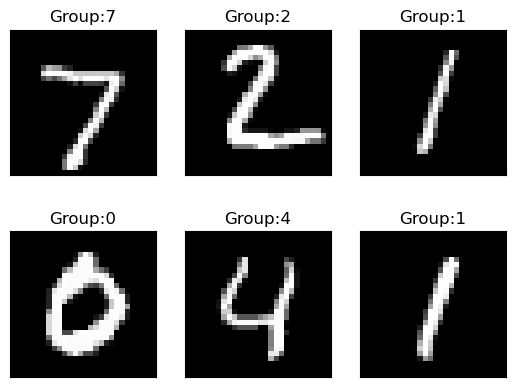

In [6]:
fig = plt.figure()
plt.tight_layout()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation=None)
    plt.title("Group:{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    

In [7]:
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x
        

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(28*28, 300, 100, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
print(device)


cuda:0


In [9]:
# 1. 定义学习率调度器（替换手动调整）
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=5,   # 每10个epoch调整一次
    gamma=0.5,      # 每次乘以0.5
    last_epoch=-1,  # 从头开始
    verbose=True    # 打印调整信息（可选）
)

/home/repiece/miniconda3/envs/ai-base/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()

    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    
    # 3. 在每个epoch结束时更新学习率
    scheduler.step()  # 自动调整学习率
    
    avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0
    avg_train_acc = train_acc / len(train_loader) if len(train_loader) > 0 else 0
    losses.append(avg_train_loss)
    acces.append(avg_train_acc)
    
    eval_loss = 0
    eval_acc = 0
    model.eval()
    
    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)
            label = label.to(device)
            img = img.view(img.size(0), -1)
            out = model(img)
            loss = criterion(out, label)
            eval_loss += loss.item()
            _, pred = out.max(1)
            num_correct = (pred == label).sum().item()
            acc = num_correct / img.shape[0]
            eval_acc += acc
    
    avg_eval_loss = eval_loss / len(test_loader) if len(test_loader) > 0 else 0
    avg_eval_acc = eval_acc / len(test_loader) if len(test_loader) > 0 else 0
    eval_losses.append(avg_eval_loss)
    eval_acces.append(avg_eval_acc)
    
    print(f'epoch: {epoch:03d}/{num_epoches-1}, '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Acc: {avg_train_acc:.4f}, '
          f'Test Loss: {avg_eval_loss:.4f}, '
          f'Test Acc: {avg_eval_acc:.4f}, '
          f'LR: {scheduler.get_last_lr()[0]:.6f}')  # 4. 使用scheduler获取学习率
    
    if epoch == 0 or avg_eval_acc > max(eval_acces[:-1]):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),  # 5. 保存调度器状态
            'train_loss': avg_train_loss,
            'eval_acc': avg_eval_acc,
        }, 'best_model.pth')

epoch: 000/19, Train Loss: 0.5222, Train Acc: 0.8827, Test Loss: 0.2055, Test Acc: 0.9500, LR: 0.010000
epoch: 001/19, Train Loss: 0.1900, Train Acc: 0.9502, Test Loss: 0.1352, Test Acc: 0.9654, LR: 0.010000
epoch: 002/19, Train Loss: 0.1333, Train Acc: 0.9647, Test Loss: 0.1075, Test Acc: 0.9711, LR: 0.010000
epoch: 003/19, Train Loss: 0.1010, Train Acc: 0.9722, Test Loss: 0.0914, Test Acc: 0.9733, LR: 0.010000
epoch: 004/19, Train Loss: 0.0833, Train Acc: 0.9775, Test Loss: 0.0804, Test Acc: 0.9777, LR: 0.005000
epoch: 005/19, Train Loss: 0.0670, Train Acc: 0.9825, Test Loss: 0.0739, Test Acc: 0.9792, LR: 0.005000
epoch: 006/19, Train Loss: 0.0597, Train Acc: 0.9847, Test Loss: 0.0722, Test Acc: 0.9793, LR: 0.005000
epoch: 007/19, Train Loss: 0.0533, Train Acc: 0.9868, Test Loss: 0.0689, Test Acc: 0.9804, LR: 0.005000
epoch: 008/19, Train Loss: 0.0490, Train Acc: 0.9882, Test Loss: 0.0684, Test Acc: 0.9802, LR: 0.005000
epoch: 009/19, Train Loss: 0.0458, Train Acc: 0.9892, Test Loss:

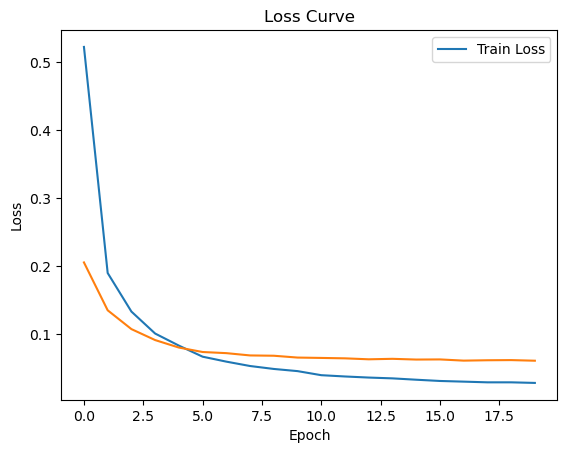

In [11]:
plt.title("Loss Curve")
plt.plot(np.arange(len(losses)), losses, label='Train Loss')
plt.plot(np.arange(len(eval_losses)), eval_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss'], loc='upper right')
plt.show()